# Bayesian inference for oceanographers
![](logo.png)

# II: Correlation

Everyone loves correlation! Correlation estimation is frequently-used approach early in your data exploration to understand whether there may be a relationship between two data series. Bayesian inference provides a framework where you can estimate probability distribution function (PDF) for the correlation coefficient. 

In this post I set out an example of how you can apply Bayesian methods to estimate correlation and uncertainty in your data.  I begin with an idealised example, before showing how it works for real ocean data.

I'll also use this as a chance to play around with some great visualisation packages that have recently arrived on the scene - Bokeh and Holoviews.

Before we get going, we need to import some packages. The full set of packages required for this post is included in the next cell. These can be installed using pip or conda on your system.


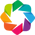

Loading BokehJS ...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Data analysis packages
import numpy as np
import xarray as xr
import pandas as pd
from scipy import signal
import pymc3 as pm
import theano
import pickle

# Visualisation packages
import holoviews as hv
import bokeh
from bokeh.plotting import figure, show

# Set visualisation options
# Use the Bokek backend of holoviews
hv.notebook_extension('bokeh')
# Set the explicit Bokeh plots to output to the notebook
bokeh.io.output_notebook()

%load_ext autoreload
%autoreload 2

## Idealised example
Before getting into some real data, we'll play around with an idealised example. In this case we create a dataset that is generated using NumPy's built in random number generator for a bivariate normal distribution:
$$ (x,y) \sim \mathcal{N}([\mu_{1},\mu_{2}],\Sigma)$$
where the $\mu_{i}$ values are the means and the covariance matrix is
$$\Sigma = \begin{bmatrix}
    \sigma_{1}^{2} & \rho\sigma_{1}\sigma_{2} \\
     \rho\sigma_{1}\sigma_{2} & \sigma_{1}^{2} \\
\end{bmatrix}$$
The full set of parameters is the mean $\mu_{1}$ and variance $\sigma_{1}^{2}$ on the first dimension, the mean $\mu_{2}$ and variance $\sigma_{2}^{2}$ on the second dimension and the correlation $\rho$ that connects the two dimensions.  

We'll be examining how well the inference performs for different values of $\rho$, so first lets create a separate dataset for values of $\rho$ between -1 and 1. To see the effect of relatively small sample sizes, we'll also keep the size of the datasets small with just 20 data points each.

In [3]:
N = 20 # Number of data points in our idealised dataset
means = np.array([ 0 , 0]) # Mean values for our bivariate normal distribution
variances = np.array([1, 1]) # Variances for our bivariate normal distribution

# We will generate datasets with correlation - which we call rho - that ranges from -1 to 1
rho = np.arange(-1,1,3e-2)
rho = rho[1:] # The end point with rho = -1 leads to a degenerate correlation matrix, so we exclude it

data = np.empty( (N, 2, len( rho ) ) ) # Pre-allocate our idealised dataset
large_data = np.empty( (100, 2, len( rho ) ) ) # Pre-allocate a dataset with many more samples
#We loop over the range of rhos to create an idealised dataset for each value of rho
for idx,r in enumerate( rho ):
    covs = np.array( [[variances[0]**2,r*variances[0]*variances[1]],[r*variances[0]*variances[1], variances[1]**2]])
    data[:,:,idx] = np.random.multivariate_normal( means, covs, N)


## Inspecting the data
As ever, the first thing to do is inspect our data. To do this, we use the holoviews package to scatterplot the data for each value of rho.
To vary the values of $\rho$ you can use drag the slider or click on it and use the left/right arrows on your keyboard.  

Before sliding, make a guess as to whether it's easier for for a spurious correlation to emerge for large or small magnitudes of $\rho$.

In [9]:
%%output size=130 # Set figure size
%%opts Scatter (size=10)
# Create a dictionary that maps each value of rho to the holoviews Scatter object
scatter_dict = {r:hv.Scatter(data[:,:,idx]) for idx,r in enumerate(rho)} 
# Read the dictionary into a HoloMap and specify the dimension for the slider dimension
scatter = hv.HoloMap(scatter_dict, kdims=['Rho']) 
# Output the scatter plot
scatter 

:HoloMap   [Rho]
   :Scatter   [x]   (y)

## Infer the correlation using Bayesian methods
As we have the data, we can now proceed to develop a Bayesian model for the correlation.  [In a previous post](http://braaannigan.github.io/bayes_moc_gaussian.html) we looked at fitting a normal distribution to a dataset. The correlation inference proceeds on a similar basis, with the difference that we fit a bivariate normal distribution to the dataset.

Although we are only after $\rho$ to get it we have to infer the full set of parameters $\mu_{1},\mu_{2},\sigma_{1},\sigma_{2}$ and $\rho$.

### Prior distributions
As in the previous post, we need to set prior distributions for each of the parameters.  In this case our prior knowledge is that we created the dataset just above, so we say that we expect $\mu_{1}$ and $\mu_{2}$ to be somewhere in the range -2 to 2 and so set:
$$\mu_{i} \sim \mathcal{N}(0,1)$$
while we expect the variance to be order 1 and so set
$$\sigma_{i} \sim \mathcal{N}^{+}(0,3)$$
where the plus sign means that only the positive side of the distribution is taken.

We set the prior for the correlation as
$$\rho \sim \textrm{Uniform}(-1,1).$$

This prior assigns equal probability to any value of $\rho$ in the range -1 to 1 [though the best way to set the prior for correlations is a subject of discussion](https://stats.stackexchange.com/questions/86484/why-not-use-beta1-1-as-boundary-avoiding-prior-on-a-transformed-correlation-pa).

### Inference strategy
We perform the inference using a Markov Chain Monte Carlo (MCMC) method.  This MCMC method is implemented in the PyMC3 package.  In this case we use a Hamiltonian Monte Carlo algorithn using the NUTS approach.  [Richard McElreath has written a nice post describing this sampling strategy](http://elevanth.org/blog/2017/11/28/build-a-better-markov-chain/).

The inference is done separately for each dataset that corresponds to a different value of $\rho$. As well as inferring the parameters, we will also generate some simulated data from our model.  We will use this simulated data to test our model below.

Bayesian inference can be computationally expensive, so I've provided some files with results of the inference below.  

The function where we implement the model and perform the inference is set out below.

In [58]:
from pymc3 import Model, Uniform, Normal, MvNormal, HalfNormal, Deterministic, sample, traceplot
import theano.tensor as ttens

def correlation(x, y, 
                mu_prior = {'mean': 0, 'sd': 1}, sigma_prior = {'sd':3}, 
                rho_prior = {'lower':-1,'upper':1}):
    """Get the correlation between x and y
    Inputs:
    x,y - numpy arrays/pandas series of same length
    priors for the parameters
    Ouputs:
    trace - PyMC3 output with results of inference
    rho_range - dictionary setting out mean rho and 95% range
    simulate_data - data simulated under the model
    output trace and summary dictionary"""
    def covariance(sigma, rho):
        """Create the covariance matrix from the array sigma and scalar rho"""
        C = ttens.alloc(rho, 2, 2)
        C = ttens.fill_diagonal(C, 1.)
        S = ttens.diag(sigma)
        return ttens.nlinalg.matrix_dot(S, C, S)

    data = np.array([x,y]) # Create a single array with the observed dataset
    with Model() as model:
        # Specify the priors for the means
        mu = Normal('mu', mu = mu_prior['mean'], sd = mu_prior['sd'], shape = 2) 
        # Specify the priors for the variances
        sigma = HalfNormal('sigma', sd = sigma_prior['sd'], shape = 2) 
        # Specify the priors for rho
        BoundedNormal = pm.Bound(pm.Normal, lower=np.array(-1.0), upper = np.array(1.0))
        rho = BoundedNormal('rho', mu=0.0, sd=1.0, testval = 0.5)
        #rho = Uniform('rho', lower = rho_prior['lower'], upper = rho_prior['upper']) 
        # Create the covariance matrix
        cov = Deterministic('cov', covariance(sigma, rho)) 
        # Specify the likelihood as a multi-variate normal distribution
        mult_n = MvNormal('mult_n', mu = mu, cov = cov, observed = data.T) 
        # Perform the inference and extract 1000 samples from the posterior distributions
        trace = pm.sample(draws = 1000) 
        # Save some summary statistics for each value of rho
        rho_range = {'mean':trace.get_values('rho').mean(),
                     '2.5':pm.stats.quantiles(trace)['rho'][2.5],
                     '97.5':pm.stats.quantiles(trace)['rho'][97.5]}
        # Simulate data from the model
        simulate_data = pm.sample_ppc(trace=trace,model=model)
    return trace, rho_range, simulate_data


You can **skip** the next cell and just load the saved outputs of the inference in the following cell.

In [13]:
# Open the saved outputs of the inference
import pickle
#np.save('rho_range',rho_range)
#pickle.dump(trace_list,open("trace_list","wb"))
#np.save("simulated_data",simulated_data)
rho_range = np.load('rho_range.npy')
simulated_data = np.load('simulated_data.npy')
trace_list = pickle.load(open("trace_list","rb"));

We now define a function to create a plot using Bokeh showing the inferred values of $\rho$ along with the uncertainty in this estimate from the model.

In [21]:
def corr_uncertainty(true_rho, est_rho, est_rho_lower, est_rho_upper, title = 'None', ylabel = None, xlabel = None):
    """Make a bokeh plot to show the probability distribution function for rho compared with its true value
    
    Inputs:
    true_rho: (1d array) - true values of rho used to generate dataset
    est_rho: (1d array) - Expectation of rho from model
    est_rho_lower: (1d array) - Lower bound for rho in 95% range
    est_rho_upper: (1d array) - Upper bound for rho in 95% range
    """
    #Have to append a reversed series for the patch coordinates
    band_x = np.append(true_rho, true_rho[::-1])
    band_y = np.append(est_rho_lower, est_rho_upper[::-1])
    p = figure(title= title, height = 700, width = 700)
    p.scatter(true_rho, est_rho, color = 'blue')
    p.line(true_rho, true_rho, line_dash="4 4", line_width=1, color='gray')
    p.patch(band_x, band_y, color='firebrick', fill_alpha=0.5, line_color = "firebrick")
    p.xaxis.axis_label = xlabel
    p.yaxis.axis_label = ylabel
    p.xaxis.bounds = (-1,1)
    p.yaxis.bounds = (-1,1)
    show(p)

We call this plot using the $rho\_range$ array that contains the mean and uncertainty ranges.  We plot the true value of the correlation as a dashed line. As this is a Bokeh plot you can use the tools on the right to zoom in.

The aim is for the inferred correlation to be close to the true value at the dashed line.  We would also hope that the uncertainty would be spread evenly above and below the dashed line close to 0 and biased towards zero as the limits at -1 and +1 are approached.

In [22]:
corr_uncertainty(rho, rho_range[:,1], rho_range[:,0], rho_range[:,2], title = 'Inferred correlation with uncertainty ranges', 
             xlabel = 'True Correlation', ylabel = 'Estimated Correlation')

### Compare inferred values of $\rho$ with the true values of $\rho$

The plot above compares the inferred values of $\rho$ with the true values of $\rho$ for this small sample size scenario.  Where the blue dots lie close to the gray dashes line the inferres values are close to the true value.  The red area captures the 95% credible range for the inferred value of the correlation.

The spread between the inferred value (blue dots) and the true value (gray line) is larger when the magnitude of $\rho$ is smaller.  At low correlations the points in a scatter plot simply form a cloud.  With a small sample size, it is not difficult to have a end up with a set of points that seem correlated when they are not correlated.
The plot below to the left shows that for low values of $\rho$ this can lead to the inferred estimate being out by as much as 0.5!

This increased uncertainty is also associated with a bulge in the 95% uncertainty range for low magnitudes of the correlation.

In [48]:
%%output size = 160
left = hv.Curve( (rho, rho_range[:,1] - rho), 
                kdims = ['True rho'], vdims = ['Error in estimation of rho'], 
                group = 'Error in mean estimation of rho',
                extents = (-1,-0.5,1,0.5))
right = hv.Curve( (rho,rho_range[:,2] - rho_range[:,1]), 
                 kdims=['True rho'], vdims = ['Spread in 95% credibility range'],
                 group = 'Bulge in uncertainty for low magnitude of correlation')
left + right

:Layout
   .Error_in_mean_estimation_of_rho.I                       :Curve   [True rho]   (Error in estimation of rho)
   .Bulge_in_uncertainty_for_low_magnitude_of_correlation.I :Curve   [True rho]   (Spread in 95% credibility range)

In the right-hand plot, we expect that the largest values of the spread in uncertainty occur for the lowest magnitudes of correlation.  However, this plot may be skewed to the left or right by the random data generation.

In any case, the uncertainty estimates show an important point - it is easier to be tricked into thinking you have a large magnitude of correlation when the true correlation is closer to 0. This potential for large error with low true correlations and small sample sizes is particularly important because publication bias means that outlier results are **more** likely to be published.

## Compare the "real" and simulated data
We can always fit a model to a dataset. The crucial step is to evaluate the model fit. We do this by simulating data under the model to see if the model is an adequate representation of the data and to understand how the model might be improved. The process of simulating data from Bayesian estimates of the parameters [was explained in a previous post](http://braaannigan.github.io/bayes_moc_gaussian.html). 

We generated this simulated data above when we did the inference and saved the 500 simulated data points for each value of $\rho$ in the array *simulated_data*. We plot this simulated data against the real data below.  You can use the slider to compare the results for different values of $\rho$.

In [49]:
%%output size=150
sim_dict = {r:hv.Scatter(simulated_data[:,:,idx]) for idx,r in enumerate(rho)} 
sim = hv.HoloMap(sim_dict, kdims=['Rho'])
sim*scatter

:HoloMap   [Rho]
   :Overlay
      .Scatter.I  :Scatter   [x]   (y)
      .Scatter.II :Scatter   [x]   (y)

The comparison of the real and simulated data confirms the impression we had from the range of uncertainty for $\rho$.  When the magnitude of the correlation is high - say $|\rho| > 0.5$, the simulated data and the real data all lie bunched tightly together.  However, when the correlation is lower we see that both the real data and the simulated data form more of a cloud. In this case the small sample size of the real dataset - just 20 independent points - means that randomness in sampling can lead to the magnitude of the correlation appearing much higher than it actually is.

# The real world

While there are few things more exciting than fitting a **bivariate normal distribution** to data generated from a **bivariate normal distribution**, we can also look at some real world data. To do this, we'll use the Meridional Overturning Circulation data [gathered by the RAPID team](http://www.rapid.ac.uk/rapidmoc/index.php). This dataset runs to February 2017.

We begin by loading and inspecing the data.  For some reason the first and last ten entries in the downloaded dataset are NaN, so we will remove them from the xarray Dataset immediately.  To work with netcdf files, we use the excellent [xarray](http://xarray.pydata.org/en/stable/) package that no climate scientist should be without.

In [50]:
# Open the dataset
ds = xr.open_dataset('data/moc_transports.nc')
# Remove the first and last ten time points from the dataset
ds = ds.isel(time=range(10,len(ds.time)-10))
# Inspect the dataset
ds

<xarray.Dataset>
Dimensions:       (time: 9411)
Coordinates:
  * time          (time) datetime64[ns] 2004-04-07 2004-04-07T12:00:00 ...
Data variables:
    t_therm10     (time) float64 ...
    t_aiw10       (time) float64 ...
    t_ud10        (time) float64 ...
    t_ld10        (time) float64 ...
    t_bw10        (time) float64 ...
    t_gs10        (time) float64 ...
    t_ek10        (time) float64 ...
    t_umo10       (time) float64 ...
    moc_mar_hc10  (time) float64 ...
Attributes:
    Title:                         RAPID MOC timeseries
    Institution:                   National Oceanography Centre,UK
    Website:                       http://www.rapid.ac.uk/rapidmoc
    Acknowledgement:               The RAPID-MOC monitoring project is funded...
    Created_by:                    Ben Moat and Gerard McCarthy
    Creation_date:                 20-Oct-2017
    Principle_investigator:        David Smeed
    Principle_investigator_email:  das@noc.ac.uk
    DOI:                 

The time series that we are going to look at are the overall MOC transport *moc_mar_hc10* and the Gulf Stream transport *t_gs10*. Before we look at correlations, we remove the seasonal cycle and any linear trend from these series.  In practice, the Gulf Stream time series is used to calculate the MOC time series, so it'd be quite surprised if there isn't a positive correlation!

Removing the seasonal cycle from a time series is straightforward when we use the groupby method in xarray or pandas.

In [73]:
# Create a dataframe to hold the two anomaly time series (with the seasonal cycle removed)
df = pd.DataFrame(columns = ['moc_anomalies', 'gs_anomalies', 'ekman_anomalies'], index = ds.time)
# Create a dataframe with the monthly climatology
climatology = ds.groupby('time.month').mean('time')
# Calculate the anomalies by removing the monthly means
moc_anomalies = (ds.moc_mar_hc10.groupby('time.month') - climatology.moc_mar_hc10).values
# Remove a small linear trend and add the output to the dataframe df
df['moc_anomalies'] = signal.detrend(moc_anomalies, axis = 0)

# Repeat this process for the Gulf Stream data
gs_anomalies = (ds.t_gs10.groupby('time.month') - climatology.t_gs10).values
df['gs_anomalies'] = signal.detrend(gs_anomalies, axis = 0)

We plot the two time series below. As we are using holoviews and Bokeh, you can use the tools on the right to **zoom** in on the plot.

In [116]:
%%opts Curve [height=700 width=900]
moc = hv.Curve( (df.index, df.moc_anomalies), kdims=['Time'], vdims=['Sverdrups'], label = 'MOC')
gs = hv.Curve( (df.index, df.gs_anomalies), kdims=['Time'], vdims=['Sverdrups'], label = 'Gulf Stream')
moc*gs

:Overlay
   .Curve.MOC         :Curve   [Time]   (Sverdrups)
   .Curve.Gulf_Stream :Curve   [Time]   (Sverdrups)

If we zoom in to the plot it is clear that both time series are strongly autocorrelated. This means that the data points cannot be considered independent of each other.  An autocorrelation analysis suggests that the autocorrelation for the series persists for about 100 days.  We take a pragmatic approach and sub-sample the two series every 100 days.

In [117]:
%%opts Curve [height=500 width=800]

df_subsample = df[::100]

moc_subsample = hv.Curve( (df_subsample.index, df_subsample.moc_anomalies), kdims=['Time (year)'], vdims=['Sverdrups'], label = 'MOC')
gs_subsample = hv.Curve( (df_subsample.index, df_subsample.gs_anomalies), kdims=['Time (year)'], vdims=['Sverdrups'], label = 'Gulf Stream')
moc_subsample*gs_subsample

:Overlay
   .Curve.MOC         :Curve   [Time (year)]   (Sverdrups)
   .Curve.Gulf_Stream :Curve   [Time (year)]   (Sverdrups)

In this sub-sampled dataset, the correlation between the two series appears to be positive, but relatively weak.  

We can examine the relationship between the two subsampled series as a scatter plot.

In [118]:
%%output size=130 # Set figure size
%%opts Scatter (size=10)
gs_comp = hv.Scatter(df_subsample,kdims=['moc_anomalies'], vdims=['gs_anomalies'])
gs_comp # Create the scatter plot

:Scatter   [moc_anomalies]   (gs_anomalies)

The scatterplot shows that there is a positive correlation between the two series, though with plenty of spread.

We now infer the probability distribution function for $\rho$ with the ```correlation``` function set out above  using PyMC3.

In [82]:
trace_moc_gs,summary_moc_gs, simulate_data_moc_gs = correlation(
    df_subsample.moc_anomalies, df_subsample.gs_anomalies) # Carry out the inference
simulate_data_moc_gs = simulate_data_moc_gs['mult_n'] # Save the simulated data for this value of rho

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average ELBO = -512.78: 100%|██████████| 200000/200000 [00:32<00:00, 6186.63it/s]
Finished [100%]: Average ELBO = -512.79
INFO:pymc3:Finished [100%]: Average ELBO = -512.79
100%|██████████| 1000/1000 [00:03<00:00, 284.04it/s]
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average ELBO = -521.84: 100%|██████████| 200000/200000 [00:32<00:00, 6138.01it/s]
Finished [100%]: Average ELBO = -521.83
INFO:pymc3:Finished [100%]: Average ELBO = -521.83
100%|██████████| 1000/1000 [00:03<00:00, 285.36it/s]


We can investigate the properties of the results of the inference by looking at the probability distribution function for $\rho$ and the samples returned by the MCMC chains.

In [120]:
%%output size=130 # Set figure size
%%opts Layout [shared_axes=False]
gs_frequencies, gs_edges = np.histogram(trace_moc_gs.get_values('rho'),20)
gs_pdf = hv.Histogram( gs_frequencies/np.sum(np.diff(gs_edges)*gs_frequencies), gs_edges, 
                      kdims=['rho'], vdims=['Probability density'],
                      group = 'PDF of rho for MOC & Gulf Stream',
                      extents = (0,0,1,8))
gs_pdf

:Histogram   [rho]   (Probability density)

The left-hand plot shows the inferred probability distribution function for $\rho$ under the model. The bulk of the probability mass is between 0.35 and 0.55.  The 95% credible range for $\rho$ is 0.3 to 0.6, so the spread is considerable.  There is no evidence from the model that the correlation is negative.

We can compare the real data points (in red) with those generated by the model (in blue) below.

In [121]:
%%output size=150
%%opts Scatter (size=5)
model_scatter = hv.Scatter(simulate_data_subsample,kdims=['moc_anomalies'], vdims=['gs_anomalies'])
data_scatter = hv.Scatter(df_subsample,kdims=['moc_anomalies'], vdims=['gs_anomalies'])
model_scatter*data_scatter

:Overlay
   .Scatter.I  :Scatter   [moc_anomalies]   (gs_anomalies)
   .Scatter.II :Scatter   [moc_anomalies]   (gs_anomalies)

This scatter plot suggests that the model is a reasonable fit for the dataset.  We could conceivabley use the model to understand the relationship between anomalies in the Gulf Stream and the MOC transport.

For example, we can estimate from the model that the probability of getting negative MOC anomalies less than -3 Sverdrups but with positive Gulf Stream anomalies is in the range 5-10%:

In [30]:
sim_df = pd.DataFrame(data=simulate_data_subsample, columns=['moc','gs'])
sim_df.loc[ (sim_df.moc < -3) & (sim_df.gs > 0),].count()/len(sim_df)

moc    0.061
gs     0.061
dtype: float64